In [1]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape, cal_score_smooth

In [2]:
stack_idx = '19'
models = '1-34,36-37'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37]


In [5]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [6]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [7]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [8]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [9]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
36
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [10]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [11]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_34,log_parea_pred_34,pred_36,log_pred_36,log_parea_pred_36,pred_37,log_pred_37,log_parea_pred_37,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.360546,12.131443,6.245441e+05,13.344779,12.115676,6.319899e+05,13.356630,12.127527,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.934792,13.538225,3.042045e+06,14.928041,13.531473,3.142342e+06,14.960479,13.563912,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.111430,14.391475,9.818275e+06,16.099756,14.379801,9.946933e+06,16.112775,14.392820,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.360720,13.753373,1.264691e+07,16.352924,13.745577,1.295773e+07,16.377203,13.769857,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.833961,12.288935,9.305770e+05,13.743561,12.198536,9.859947e+05,13.801407,12.256382,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_33,pred_34,log_pred_34,log_parea_pred_34,pred_36,log_pred_36,log_parea_pred_36,pred_37,log_pred_37,log_parea_pred_37
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.177853,1.265085e+07,16.353235,15.124128,1.298618e+07,16.379396,15.150290,1.304845e+07,16.384180,15.155073
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.129452,3.890897e+06,15.174151,13.129532,3.897411e+06,15.175823,13.131204,3.897545e+06,15.175858,13.131239
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.676769,1.078313e+07,16.193493,13.694473,1.049745e+07,16.166643,13.667623,1.035078e+07,16.152573,13.653552
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.815015,6.080412e+06,15.620583,14.808651,6.139949e+06,15.630327,14.818395,6.120593e+06,15.627170,14.815237
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.159895,1.092040e+06,13.903559,12.143297,1.106728e+06,13.916919,12.156657,1.098338e+06,13.909310,12.149048


### Check models scores

In [12]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194
27 model-28 5901.874202
28 model-29 5884.873848
29 model-30 5864.872101
30 model-31 5783.868923
31 model-32 5930.875106
32 model-33 5976.875715
33 model-34 5942.875172
34 model-36 5989.876236
35 model-37 5980.875836


In [13]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [14]:
def objective(x, cv, metric, best_score, best_coeffs, verbose):
    cv_pred_final = cv[cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        if verbose:
            print('find better score:')
            print('score: ', score)
            print('coeffs: ', x)
            print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

In [15]:
len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [[1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       (np.random.randn(len_x)+1)/len_x,
       (np.random.randn(len_x)+1)/len_x,
       (np.random.randn(len_x)+1)/len_x,
      ]
bounds = tuple([(0, 1) for i in range(len_x-1)] + [(-2, 2)])

### CV
(skip)

In [15]:
from sklearn.model_selection import KFold

cv = cv.reset_index(drop=True)
#cv = cv.head(100)

score_list = []

kf = KFold(shuffle= True)
for idx_train, idx_val in kf.split(cv):

    best_score = {}
    best_coeffs = {}
    
    cv_fold_train = cv.loc[idx_train].reset_index(drop=True)
    cv_fold_val = cv.loc[idx_train].reset_index(drop=True)
    
    for metric in ['smooth']:
    #for metric in ['mape', 'mae', 'mse']:
        best_score[metric] = 0
        best_coeffs[metric] = []
        for x0 in x0s:
            print('Optimizing with init x0: {}'.format(x0))
            print()
            minimize(objective, x0, args=(cv_fold_train, metric, best_score, best_coeffs, 
                                          True), 
                     tol=1e-4) #, bounds=bounds
    
    val_pred_final = cv_fold_val[cols_opt].dot(best_coeffs['smooth'])
    if is_per_area:
        val_pred_final = np.expm1(val_pred_final) * cv_fold_val['building_area']
    else:
        val_pred_final = np.expm1(val_pred_final)
    score = cal_score(cv_fold_val['total_price'], val_pred_final)
    
    score_list.append(score)

print('CV score ?: {}; {}'.format(np.mean(score_list), score_list))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [ 0.03846021  0.00062566 -0.03117297  0.0022633  -0.03071847  0.01749487
  0.08838549  0.00329446  0.09265428 -0.0070245   0.04951577  0.07034371
  0.05030559  0.03186655  0.03716567  0.01666125 -0.01613149  0.06202454
  0.03040203  0.03326463  0.05830177 -0.04199244  0.02952393 -0.00491137
  0.02777167  0.00680121 -0.01672517  0.04532399]

Optimizing with init x0: [ 0.06978301  0.00716537  0.01933011 -0.04041742  0.03065218 -0.0445668
  0.02177403  0.09387119 -0.0091588   0.04360813  0.0228007   0.00906132
  0.02944168  0.08750569  0.03127045  0.07687615  0.02886889  0.01880305
 -0.02339895  0.00698907 -0.03777497  0.03324249  0.05073555  0.02176212
  0.07462535  0.06523475 -0.04306402  0.06929561]

Optimizing with init x0: [ 0.04733216  0.01769283  0.06722644  0.0327374   0.02392443  0.0763044
  0.00937986  0.02932873  0.02586816  0.08313561  0.0832105   0.04584757
 -0.04382431  0.06313654  0.07997944  0.02523787  0.03105419  0.01871397
  0.00151872  0.062555

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [ 0.03846021  0.00062566 -0.03117297  0.0022633  -0.03071847  0.01749487
  0.08838549  0.00329446  0.09265428 -0.0070245   0.04951577  0.07034371
  0.05030559  0.03186655  0.03716567  0.01666125 -0.01613149  0.06202454
  0.03040203  0.03326463  0.05830177 -0.04199244  0.02952393 -0.00491137
  0.02777167  0.00680121 -0.01672517  0.04532399]

Optimizing with init x0: [ 0.06978301  0.00716537  0.01933011 -0.04041742  0.03065218 -0.0445668
  0.02177403  0.09387119 -0.0091588   0.04360813  0.0228007   0.00906132
  0.02944168  0.08750569  0.03127045  0.07687615  0.02886889  0.01880305
 -0.02339895  0.00698907 -0.03777497  0.03324249  0.05073555  0.02176212
  0.07462535  0.06523475 -0.04306402  0.06929561]

Optimizing with init x0: [ 0.04733216  0.01769283  0.06722644  0.0327374   0.02392443  0.0763044
  0.00937986  0.02932873  0.02586816  0.08313561  0.0832105   0.04584757
 -0.04382431  0.06313654  0.07997944  0.02523787  0.03105419  0.01871397
  0.00151872  0.062555

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [ 0.03846021  0.00062566 -0.03117297  0.0022633  -0.03071847  0.01749487
  0.08838549  0.00329446  0.09265428 -0.0070245   0.04951577  0.07034371
  0.05030559  0.03186655  0.03716567  0.01666125 -0.01613149  0.06202454
  0.03040203  0.03326463  0.05830177 -0.04199244  0.02952393 -0.00491137
  0.02777167  0.00680121 -0.01672517  0.04532399]

Optimizing with init x0: [ 0.06978301  0.00716537  0.01933011 -0.04041742  0.03065218 -0.0445668
  0.02177403  0.09387119 -0.0091588   0.04360813  0.0228007   0.00906132
  0.02944168  0.08750569  0.03127045  0.07687615  0.02886889  0.01880305
 -0.02339895  0.00698907 -0.03777497  0.03324249  0.05073555  0.02176212
  0.07462535  0.06523475 -0.04306402  0.06929561]

Optimizing with init x0: [ 0.04733216  0.01769283  0.06722644  0.0327374   0.02392443  0.0763044
  0.00937986  0.02932873  0.02586816  0.08313561  0.0832105   0.04584757
 -0.04382431  0.06313654  0.07997944  0.02523787  0.03105419  0.01871397
  0.00151872  0.062555

### Optimize

In [16]:
best_score = {}
best_coeffs = {}

for metric in ['smooth']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(cv, metric, best_score, best_coeffs, True), tol=1e-4)

Optimizing with init x0: [0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703]

find better score:
score:  528.7076148557613
coeffs:  [0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702

find better score:
score:  5921.8758365628855
coeffs:  [0.02768826 0.02768814 0.02768823 0.02768833 0.02768815 0.02768823
 0.02768774 0.02768817 0.02768819 0.0276882  0.02768944 0.02768828
 0.02768829 0.02768822 0.02768822 0.02768823 0.02768821 0.0276882
 0.02768822 0.02768823 0.02768818 0.02768816 0.02768819 0.02768819
 0.02768821 0.02768823 0.02768817 0.02768823 0.0276882  0.02768812
 0.02768825 0.02768817 0.02768813 0.02768816 0.02768808 0.02768804
 0.02707716]

find better score:
score:  5921.875836573617
coeffs:  [0.02768828 0.02768814 0.02768823 0.02768833 0.02768815 0.02768823
 0.02768774 0.02768817 0.02768819 0.0276882  0.02768944 0.02768828
 0.02768829 0.02768822 0.02768822 0.02768823 0.02768821 0.0276882
 0.02768822 0.02768823 0.02768818 0.02768816 0.02768819 0.02768819
 0.02768821 0.02768823 0.02768817 0.02768823 0.0276882  0.02768812
 0.02768825 0.02768817 0.02768813 0.02768816 0.02768808 0.02768804
 0.02707716]

find better score:
score:  5921.8758365736385
coeffs:  [0.027

find better score:
score:  6032.878593159788
coeffs:  [-0.02277119  0.029507    0.04427154 -0.01285329  0.10126435  0.02017544
  0.02143604  0.07360453 -0.02480761 -0.00944561 -0.08817088  0.00095247
  0.0448999   0.00163046  0.01268057  0.02133307  0.04801808  0.01219837
 -0.09942061 -0.09847021 -0.02243784 -0.05281199  0.05497072  0.10074328
 -0.12520418 -0.0217677   0.2260912  -0.06222849  0.00326915  0.07408066
  0.07763793 -0.1268708   0.10594463 -0.11468579  0.31644191  0.49893641
 -0.11625347]

find better score:
score:  6043.878669613554
coeffs:  [-0.02481838  0.02341519  0.05345714  0.00372843  0.11882754  0.0250469
  0.02643662  0.05856711 -0.02316829 -0.02045843 -0.10043108  0.02476975
  0.03195325 -0.00901263  0.00930856  0.01848037  0.05687567  0.00527976
 -0.11241325 -0.11010929 -0.01613941 -0.04912807  0.03497402  0.08884512
 -0.14593355 -0.02315558  0.23018148 -0.06406293  0.00248318  0.06202331
  0.07544532 -0.10537559  0.08133387 -0.08851004  0.32643347  0.54075097
 -

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [-4.52152323e-03  5.56103191e-02  3.20549709e-02 -2.22639125e-02
 -4.99122548e-02  1.28073710e-02 -2.22958707e-03  3.80858999e-02
  3.43723895e-02  4.63502444e-02 -9.37565795e-03  4.49006545e-02
 -3.84241488e-05  1.66862596e-02  3.34355187e-02  1.48045975e-02
  4.94707194e-02  2.40915488e-02 -1.85167712e-03  2.66944106e-02
 -1.08517871e-02  6.58085815e-03  4.55037708e-02  4.42926560e-02
  1.35931991e-02  3.82700369e-02  1.34676001e-02  4.56270965e-02
  7.76483558e-02  3.59042662e-02  3.33388515e-02  2.64755613e-02
  3.75101649e-02  4.99731949e-02  1.30677342e-02  3.21550092e-02
  4.04994866e-02]

find better score:
score:  6049.878642911193
coeffs:  [-0.0662279   0.01728208  0.05598231 -0.00381111  0.14698154  0.02335327
  0.02828085  0.06887918 -0.0264824  -0.12899839 -0.10743578 -0.00252525
  0.04062566 -0.21360138  0.12528819  0.02178604  0.4132497  -0.10334989
 -0.31968853 -0.20731687  0.03800755 -0.13244829  0.03527936  0.10161471
 -0.41255174  0.23621531 

In [17]:
display(best_score)
display(best_coeffs)

{'smooth': 6049.878642911193}

{'smooth': array([-0.0662279 ,  0.01728208,  0.05598231, -0.00381111,  0.14698154,
         0.02335327,  0.02828085,  0.06887918, -0.0264824 , -0.12899839,
        -0.10743578, -0.00252525,  0.04062566, -0.21360138,  0.12528819,
         0.02178604,  0.4132497 , -0.10334989, -0.31968853, -0.20731687,
         0.03800755, -0.13244829,  0.03527936,  0.10161471, -0.41255174,
         0.23621531,  0.24931676,  0.15372999,  0.00090934,  0.08237545,
         0.07381691, -0.18065202, -0.23235677,  0.14527066,  0.45944308,
         0.62370872, -0.05774944])}

### Compute submission

In [18]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['smooth'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

In [19]:
unique_prices = np.sort(df_train['total_price'].unique())

def find_nearest(array, value):
    return array[(np.fabs(array - value)).argmin()]

def correct_prices(sq):
    return [find_nearest(unique_prices, x) for x in sq]

test_pred_final['total_price'] = correct_prices(test_pred_final['total_price'])

In [21]:
if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}_smoothobj.csv'.format(stack_idx, models), index=False)

### Plots

In [22]:
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


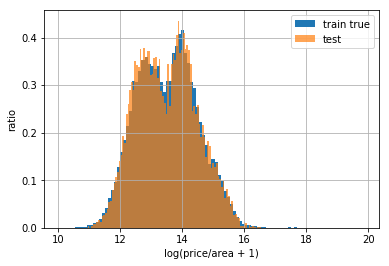

In [23]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


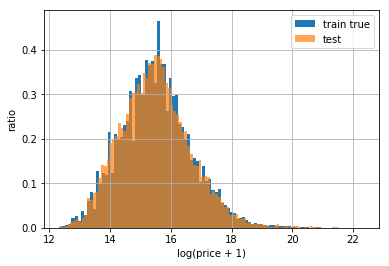

In [24]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


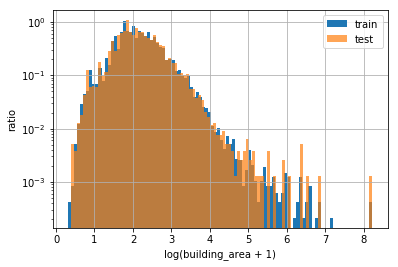

In [25]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

### mean-log

In [27]:
idxs = [12, 23, 32, 33, 34, 36]
models = list(range(1,35)) + [36]
print([1/len(idxs) if i in idxs else 0 for i in models])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


### mean

In [28]:
idxs = [36]
models = list(range(1,35)) + [36]
print([1/len(idxs) if i in idxs else 0 for i in models])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
